In [1]:
import seaborn as sns
from datetime import datetime
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/g-research-crypto-forecasting/example_sample_submission.csv
/kaggle/input/g-research-crypto-forecasting/asset_details.csv
/kaggle/input/g-research-crypto-forecasting/example_test.csv
/kaggle/input/g-research-crypto-forecasting/train.csv
/kaggle/input/g-research-crypto-forecasting/supplemental_train.csv
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/__init__.py


# 1. Leer los datos

Leer los datasets desde 'g-research-crypto-forecasting datasets

In [2]:
train_data = pd.read_csv('/kaggle/input/g-research-crypto-forecasting/train.csv')
asset_ID = pd.read_csv('/kaggle/input/g-research-crypto-forecasting/asset_details.csv')

In [3]:
asset_ID

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


# **2. Explorando los datos**
Se selecciona el Bitcoin. El Bitcoin es Asset_ID == 1

In [4]:
Bitcoin = train_data[train_data['Asset_ID'] == 1]

Bitcoin.head(10)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
2,1514764860,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
10,1514764920,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
18,1514764980,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
26,1514765040,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
34,1514765100,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079
42,1514765160,1,554.0,13717.714,14000.7,13520.00,13717.112,70.805776,13706.952030,-0.004422
50,1514765220,1,546.0,13720.922,14001.4,13501.01,13670.940,70.762103,13683.843336,-0.008873
58,1514765280,1,437.0,13669.246,13914.6,13504.99,13721.348,78.298555,13701.600413,-0.008492
66,1514765340,1,288.0,13713.412,13948.9,13539.99,13720.260,60.100796,13720.524584,-0.006282
74,1514765400,1,270.0,13713.610,13948.5,13530.00,13719.902,56.578007,13711.904983,-0.003889


In [5]:
correlation=Bitcoin.corr()

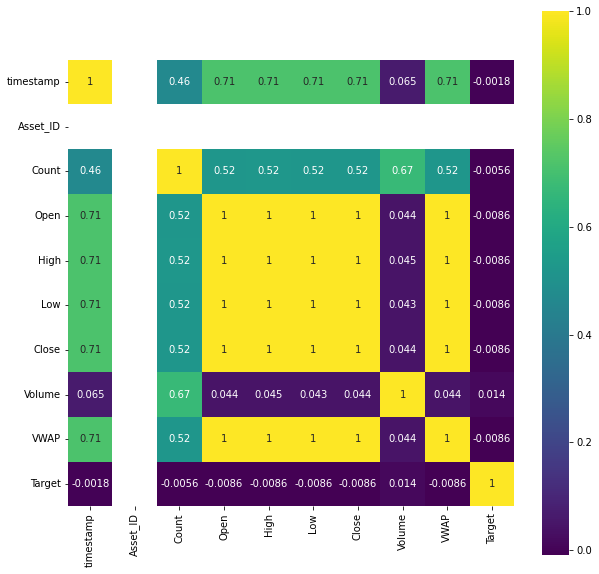

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
ax = sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='viridis')
plt.title = 'Matriz de Correlación'
plt.show()

In [7]:
Bitcoin.skew()

timestamp   -0.000042
Asset_ID     0.000000
Count        7.245120
Open         1.663233
High         1.664121
Low          1.663196
Close        1.663229
Volume       9.628004
VWAP         1.663232
Target       1.429659
dtype: float64

In [8]:
Bitcoin.isnull().sum()

timestamp      0
Asset_ID       0
Count          0
Open           0
High           0
Low            0
Close          0
Volume         0
VWAP           0
Target       304
dtype: int64

Los datos que faltan, para un minuto dado, no están representados por NaN, sino por la ausencia de filas. Podemos verificar la diferencia de marca de tiempo entre filas consecutivas para ver si faltan datos.

In [9]:
(Bitcoin.index[1:]-Bitcoin.index[:-1]).value_counts().head()

14    596514
12    495202
13    443611
11    214273
8      78696
dtype: int64

# **3. Limpieza de datos**
Se eliminan los valores nulos.

In [10]:
Bitcoin = Bitcoin.reindex(range(Bitcoin.index[0], Bitcoin.index[-1], 60), method = 'pad')

In [11]:
Bit_coin = Bitcoin.copy()

In [12]:
Bitcoin = Bitcoin.Close.fillna(method = 'pad')

Aparecen eliminados los valores nulos ya que comprobamos que no hay lagunas de tiempo ahora.



In [13]:
(Bitcoin.index[1:]-Bitcoin.index[:-1]).value_counts().head()

60    403946
dtype: int64

# **4. Preprocesamiento de datos para el modelo Deep Learning**
## Se dividen el conjunto de datos en train_data y test_data


In [14]:
import math
Bitcoin_Target = Bitcoin.values
train_len = math.ceil(len(Bitcoin_Target) * 0.8)

In [15]:
Bitcoin_Target = Bitcoin_Target.reshape(-1, 1)

## Se escalan los datos 

Se usa el MinMaxScaler metodo para escalar los datos

In [16]:
from sklearn.preprocessing import MinMaxScaler
Normalize = MinMaxScaler(feature_range=(0, 1))
Bitcoin_Target = Normalize.fit_transform(Bitcoin_Target)

In [17]:
bit_train_data, bit_test_data = Bitcoin_Target[0:train_len, :], Bitcoin_Target[train_len:len(Bitcoin_Target), :1]

## Se preparan los datos para la serie temporal


In [18]:
x_train = []
y_train = []
for i in range(100, len(bit_train_data)):
   x_train.append(bit_train_data[i-100:i, 0])
   y_train.append(bit_train_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [19]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

Los datos desde el No.0 hasta No.99 pertenecen a x_test y la predicción No.100's a y_test

In [20]:
x_test = []
y_test = []
for i in range(100, len(bit_test_data)):
   x_test.append(bit_test_data[i-100:i, 0])
   y_test.append(bit_test_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)

In [21]:
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [22]:
x_train.shape

(323058, 100, 1)

# **5. Deep Learning LSTM Model**

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, TimeDistributed, Flatten
from tensorflow.keras.utils import plot_model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer = 'adam')
history = model.fit(x_train,y_train, batch_size = 512 , epochs = 30)

2022-07-27 21:29:05.539839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 21:29:05.629857: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 21:29:05.630603: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 21:29:05.631831: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/30


2022-07-27 21:29:13.331334: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


631/631 [==============================] - 22s 26ms/step - loss: 1.0248e-04
Epoch 2/30
631/631 [==============================] - 16s 26ms/step - loss: 2.7080e-06
Epoch 3/30
631/631 [==============================] - 16s 26ms/step - loss: 2.6457e-06
Epoch 4/30
631/631 [==============================] - 16s 26ms/step - loss: 2.9568e-06
Epoch 5/30
631/631 [==============================] - 16s 26ms/step - loss: 2.9319e-06
Epoch 6/30
631/631 [==============================] - 16s 26ms/step - loss: 3.0291e-06
Epoch 7/30
631/631 [==============================] - 16s 26ms/step - loss: 3.1288e-06
Epoch 8/30
631/631 [==============================] - 16s 26ms/step - loss: 2.6285e-06
Epoch 9/30
631/631 [==============================] - 16s 26ms/step - loss: 2.3133e-06
Epoch 10/30
631/631 [==============================] - 16s 26ms/step - loss: 2.1396e-06
Epoch 11/30
631/631 [==============================] - 16s 26ms/step - loss: 2.0594e-06
Epoch 12/30
631/631 [==============================]

<AxesSubplot:ylabel='loss'>

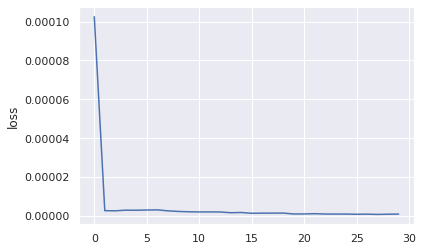

In [24]:
sns.set()
df_history = pd.DataFrame(history.history)
sns.lineplot(x = df_history.index, y = df_history.loss)

# **6. Comparación entre realidad y predicción**

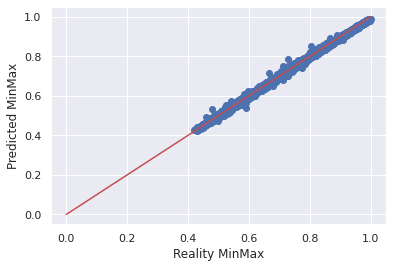

<Figure size 432x288 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt
y_pred = model.predict(x_test)
plt.scatter(y_test, y_pred)
plt.plot([x for x in range(2)], [x for x in range(2)], color = 'r')
plt.xlabel("Reality MinMax")
plt.ylabel("Predicted MinMax")
plt.show()
plt.clf()

#### No MinMaxScaler comparación entre prediction(y_pred) precio y reality(y_test) precio

In [26]:
y_pred = model.predict(x_test)
y_test = y_test.reshape(-1, 1)
y_pred = Normalize.inverse_transform(y_pred)
y_test = Normalize.inverse_transform(y_test)
y_pred = y_pred.reshape(len(y_pred), 1)
y_test = y_test.reshape(len(y_pred), 1)

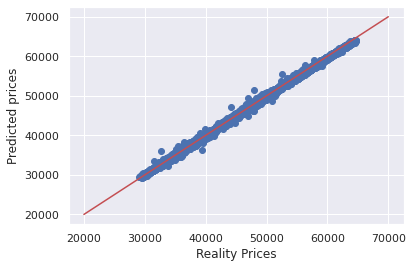

<Figure size 432x288 with 0 Axes>

In [27]:
plt.scatter(y_test, y_pred)
plt.plot([10000*x for x in range(2, 8)], [10000*x for x in range(2, 8)], color = 'r')
plt.xlabel("Reality Prices")
plt.ylabel("Predicted prices")
plt.show()
plt.clf()

In [28]:
df_pred = pd.DataFrame(y_pred, columns = ['Prediction'], index = Bitcoin.index[train_len +100:])
df_pred['Reality'] = y_test

In [29]:
df_pred

,Prediction,Reality
19395482,32241.078125,32381.508571
19395542,32342.724609,32338.621954
19395602,32370.824219,32289.888750
19395662,32330.468750,32355.902857
19395722,32336.675781,32343.772500
...,...,...
24236522,42716.140625,42703.636250
24236582,42732.578125,42657.202500
24236642,42692.546875,42898.565000
24236702,42817.097656,42960.601429


In [30]:
def log_return(close):
    return np.log(close).diff(periods = 15)

In [31]:
Bitcoin_Target[train_len:len(Bitcoin_Target), :1]

array([[0.4668995 ],
       [0.46767275],
       [0.46717937],
       ...,
       [0.6461057 ],
       [0.64711422],
       [0.64547885]])

In [32]:
df_pred['Log_return_prediction'] = log_return(df_pred['Prediction'])[15: ]
df_pred['Log_return_reality'] = log_return(df_pred['Reality'])[15: ]

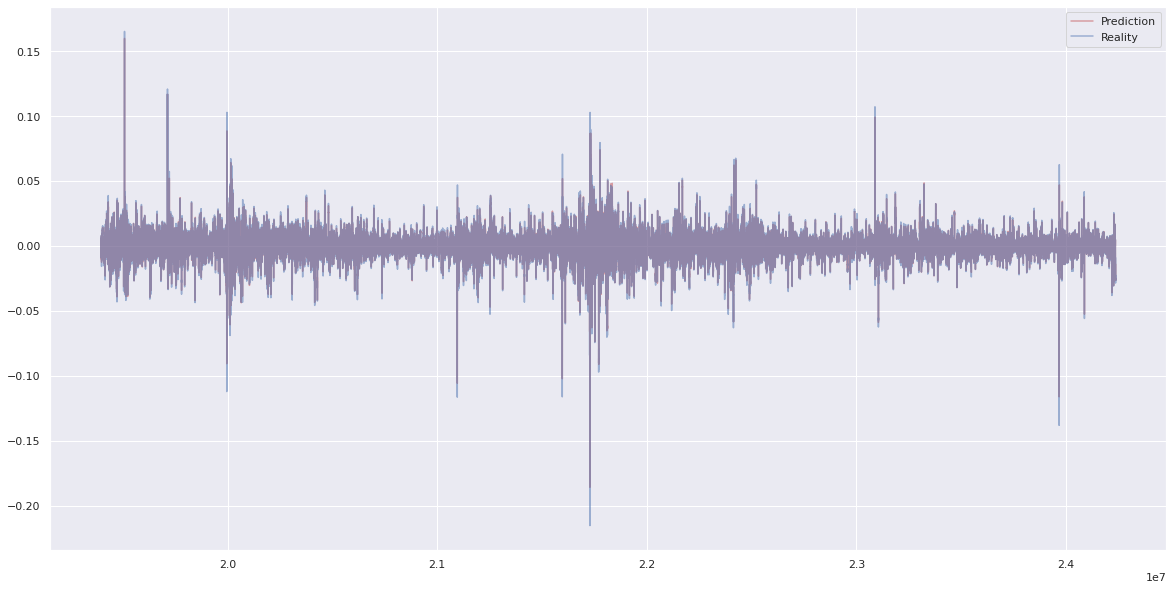

In [33]:
plt.figure(figsize=(20,10))
plt.plot(df_pred['Log_return_prediction'], color = 'r' , label = 'Prediction', alpha = 0.5)
plt.plot(df_pred['Log_return_reality'], color = 'b', label = 'Reality', alpha = 0.5)
plt.legend()
plt.show()

### Comparación realidad y predicción.

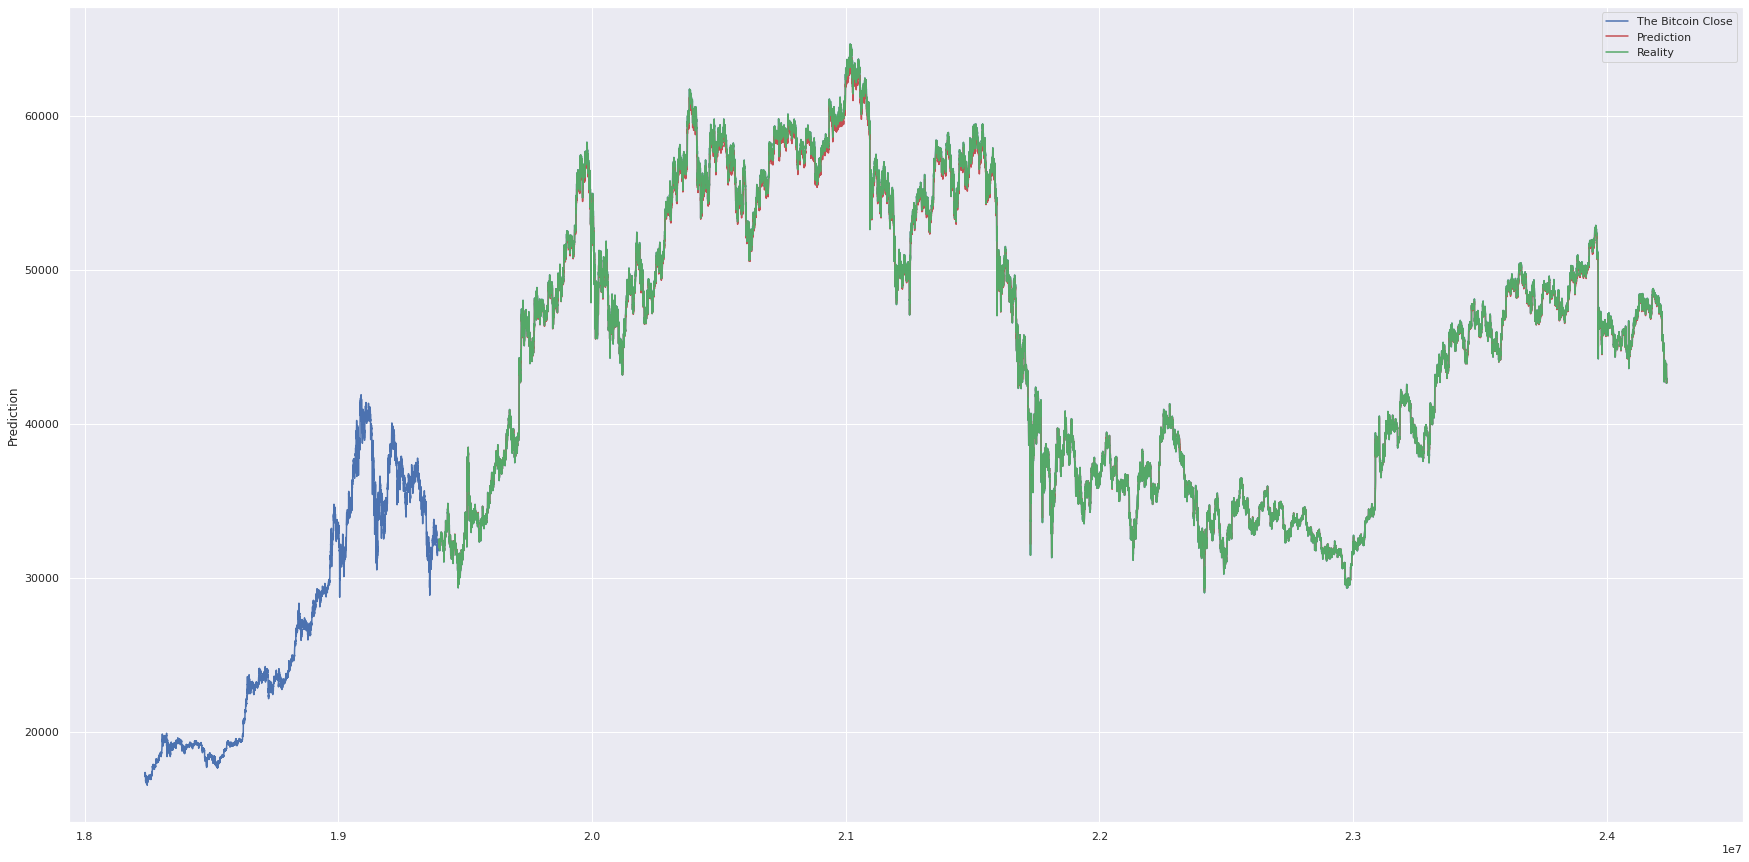

In [34]:
plt.figure(figsize = (30, 15))
sns.lineplot(x = Bitcoin.index[-100000:], y = Bitcoin.values[-100000:], label = f'The Bitcoin Close')
sns.lineplot(x = df_pred.index, y = df_pred.Prediction, label = 'Prediction', color = 'r')
sns.lineplot(x = df_pred.index, y = df_pred.Reality, label = 'Reality', color = 'g')
plt.legend()
plt.show()